In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

from sklearn.svm import SVC, LinearSVC
from sklearn.datasets import make_blobs

In [2]:
# blue
color_0 = '#1f77b4'
color_0_light = '#8fbbd9'

# orange
color_1 = '#ff7f0e'
color_1_light = '#ffbf86'

cmap = LinearSegmentedColormap.from_list('blue_orange', [color_0_light, '#FFFFFF', color_1_light], N=100)

# Support Vector Machine (SVM)

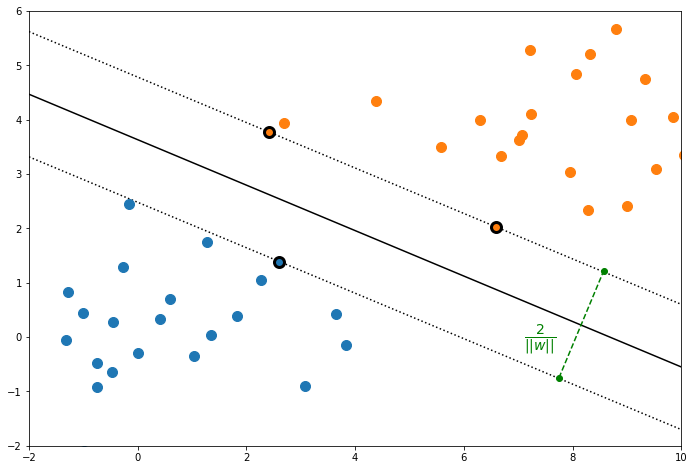

In [3]:
X, y = make_blobs(n_samples=50, n_features=2, centers=np.array([[0,0], [4,4]]), random_state=9)
X[:, 0] = 2* X[:, 0]

svc = SVC(kernel='linear')
svc.fit(X, y)

fig, ax = plt.subplots(figsize=(12, 8))
s = 100

# decision boundary
x = np.linspace(-2, 10, 50)
ax.plot(x, - 1/svc.coef_[0][1] * (svc.coef_[0][0]*x + svc.intercept_), color='k')

# margin
b_0 = np.dot(svc.support_vectors_[0], svc.coef_[0])
ax.plot(x, - 1/svc.coef_[0][1] * (svc.coef_[0][0]*x - b_0), color='k', linestyle=':', zorder=0)
b_1 = np.dot(svc.support_vectors_[1], svc.coef_[0])
ax.plot(x, - 1/svc.coef_[0][1] * (svc.coef_[0][0]*x - b_1), color='k', linestyle=':', zorder=0)

# data
ax.scatter(X[:,0][y==0], X[:,1][y==0], color=color_0, s=s)
ax.scatter(X[:,0][y==1], X[:,1][y==1], color=color_1, s=s)

# highlight support vectors
ax.scatter(X[:,0][svc.support_][y[svc.support_]==0], X[:,1][svc.support_][y[svc.support_]==0], color=color_0, edgecolors='k', s=s, linewidth=3)
ax.scatter(X[:,0][svc.support_][y[svc.support_]==1], X[:,1][svc.support_][y[svc.support_]==1], color=color_1, edgecolors='k', s=s, linewidth=3)

# cosmetics
ax.set(ylim=(-2, 6), xlim=(-2, 10))

ax.text(7.1, -0.1, r'$\frac{2}{||w||}$', fontdict={'size': 20}, color='g')
x_margin = np.linspace(7.75, 8.57, 2)
ax.plot(x_margin, 1/svc.coef_[0][0] * (svc.coef_[0][1]*x_margin - 7) , color='g', linestyle='--', marker='o')

ax.set_aspect(1)

### Primal optimization problem
- Explicit calculation of the feature vectors (the kernel trick cannot be directly applied)

![test](primal.png)

### Dual optimization problem
- Kernel trick can be applied
- Standard way to fit the SVM model in `sklearn` and `qiskit-machine-learning`

![test](dual.png)

# Quantum Support Vector Machine (QSVM)

### Quantum feature map
- Maps from real data space to space of density matrices
- Defined by applying a quantum circuit which is parameterized by the datum $\mathbf{x}$ to the all zero state

![test](quantum_feature_map.png)

### Quantum kernel function
- Makes use of the Hilbert-Schmidt inner product like

![test](quantum_kernel_function.png)

# Pegasos
- "Primal Estimated sub-GrAdient SOlver for SVM" from https://home.ttic.edu/~nati/Publications/PegasosMPB.pdf
- Allows application of the kernel trick
- Alternative to the dual optimization
- Finds a $\delta$ accurate solution

### Algorithm
![test](pegasos_algorithm.png)

### Typical run
![test](pegasos_run.png)


### Motivation
- Pegasos has polynomial speedup over training via the dual optimization problem

|  | dual optimization | Pegasos algorithm|
| --- | --- | --- |
| ideal kernel evaluations (classical) | $\mathcal{O}\left(M^2\right)$ | $\mathcal{O}\left(\frac{M}{\delta}\right)$ |
| ideal quantum circuit evaluations | $\mathcal{O}\left(\frac{M^{4.67}}{\epsilon^2}\right)$ | $\mathcal{O}\left(\text{min}\left[\frac{M^2}{\delta^3}, \frac{1}{\delta^5}\right]\right)$ |

- $M$ size of the training set
- $\epsilon$ absolute difference between ideal and noisy decision function
- $\delta$ accuracy of the optimization

### Examples

#### imports

In [4]:
import sys
import os
from sklearn.preprocessing import MinMaxScaler
from qiskit import BasicAer
from qiskit.utils import QuantumInstance, algorithm_globals
from qiskit.circuit.library import ZFeatureMap, ZZFeatureMap
from qiskit_machine_learning.kernels import QuantumKernel

# import the implementation of Pegasos
sys.path.insert(1, os.path.join(sys.path[0], 'C:/Users/4rnet/git/qiskit-machine-learning/qiskit_machine_learning/algorithms/classifiers/'))
from pegasos_qsvc import PegasosQSVC

#### functions

In [5]:
def make_meshgrid(X, h=.02):
    """
    :param X: ndarray of shape (x_samples, 2)
    :param h: float, stepsize for meshgrid
    :return: ndarray
    """
    assert X.shape[1] == 2
    
    x_min, x_max = X[:,0].min() - 0.1*X[:,0].max(), X[:,0].max() + 0.1*X[:,0].max()
    y_min, y_max = X[:,1].min() - 0.1*X[:,1].max(), X[:,1].max() + 0.1*X[:,1].max()
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    return xx, yy

#### data

In [6]:
# example dataset
sample, label = make_blobs(
    n_samples=20, n_features=2, centers=2, random_state=3, shuffle=True
)
# preprocessing to ensure compatibility with the rotation encoding
sample = MinMaxScaler(feature_range=(0, np.pi)).fit_transform(sample)
# split into train and test set
sample_train = sample[:15]
label_train = label[:15]
sample_test = sample[15:]
label_test = label[15:]

#### hyperparemeters

In [7]:
# number of qubits is equal to the number of features
q = 2
# number of steps performed during the training procedure
tau = 100
# regularization parameter
C = 1000

- For Pegasos, the runtime depends on the regularization parameter `C`
- The larger `C`, the faster the algorithm runs
- The black fit corresponds to $C^{-0.55}$

![test](final_kernel_evals(C)_log_log.png)

#### quantum kernel function

In [8]:
feature_map = ZFeatureMap(feature_dimension=q, reps=1)

statevector_simulator = QuantumInstance(
    BasicAer.get_backend("statevector_simulator"),
    shots=1,
    seed_simulator=algorithm_globals.random_seed,
    seed_transpiler=algorithm_globals.random_seed,
)

qkernel = QuantumKernel(
    feature_map=feature_map, quantum_instance=statevector_simulator
)

#### standard usage

In [9]:
pegasos_qsvc = PegasosQSVC(quantum_kernel=qkernel, C=C, num_steps=tau)

# training
pegasos_qsvc.fit(sample_train, label_train)

# testing
score = pegasos_qsvc.score(sample_test, label_test)
print(f'test score = {score}')

test score = 1.0


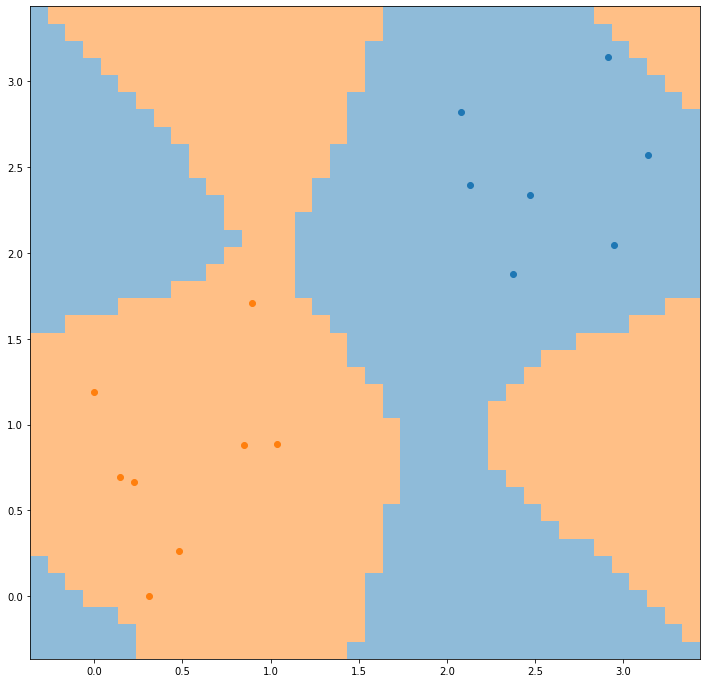

In [10]:
# plot
fig, ax = plt.subplots(figsize=(12,12))
xx, yy = make_meshgrid(sample_train[:, :2], h=0.1)

# prediction
Z = pegasos_qsvc.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
ax.pcolormesh(xx, yy, Z, cmap=cmap, shading='auto')

# data
ax.scatter(sample_train[:,0][label_train==0], sample_train[:,1][label_train==0], color=color_0)
ax.scatter(sample_train[:,0][label_train==1], sample_train[:,1][label_train==1], color=color_1)

#### precomputed kernel matrix
- technically pointless because the whole kernel matrix has to be computed, but when the quantum circuits are simulated on a classical computer, this is faster than calculating the kernel values on the fly because of optimizations in the `QuantumKernel` class 

In [11]:
pegasos_qsvc = PegasosQSVC(C=C, num_steps=tau, precomputed=True)

# training
kernel_matrix_train = qkernel.evaluate(sample_train, sample_train)
pegasos_qsvc.fit(kernel_matrix_train, label_train)

# testing
kernel_matrix_test = qkernel.evaluate(sample_test, sample_train)
score = pegasos_qsvc.score(kernel_matrix_test, label_test)
print(f'test score = {score}')

test score = 1.0
